In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2 as cv

import IPython.display as display
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV

from skimage.transform import resize
from skimage.io import imread


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

2.5.0


In [3]:
colon_main = pd.read_csv("./Image_classification_data/data_labels_mainData.csv")

In [36]:
colon_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [5]:
colon_main.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

In [6]:
colon_main.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

In [4]:
train_data, test_data = train_test_split(colon_main, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, \nVal Data: {}, \nTest Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, 
Val Data: 1979, 
Test Data: 1980


In [5]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [128]:
colon_main.cellType.value_counts()

2    4079
1    2543
0    1888
3    1386
Name: cellType, dtype: int64

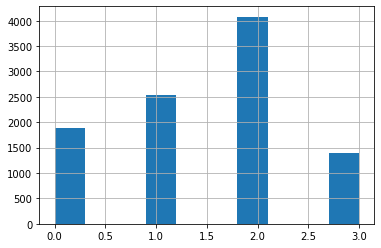

In [129]:
colon_main.cellType.hist()
plt.show()

Text(0, 0.5, 'other')

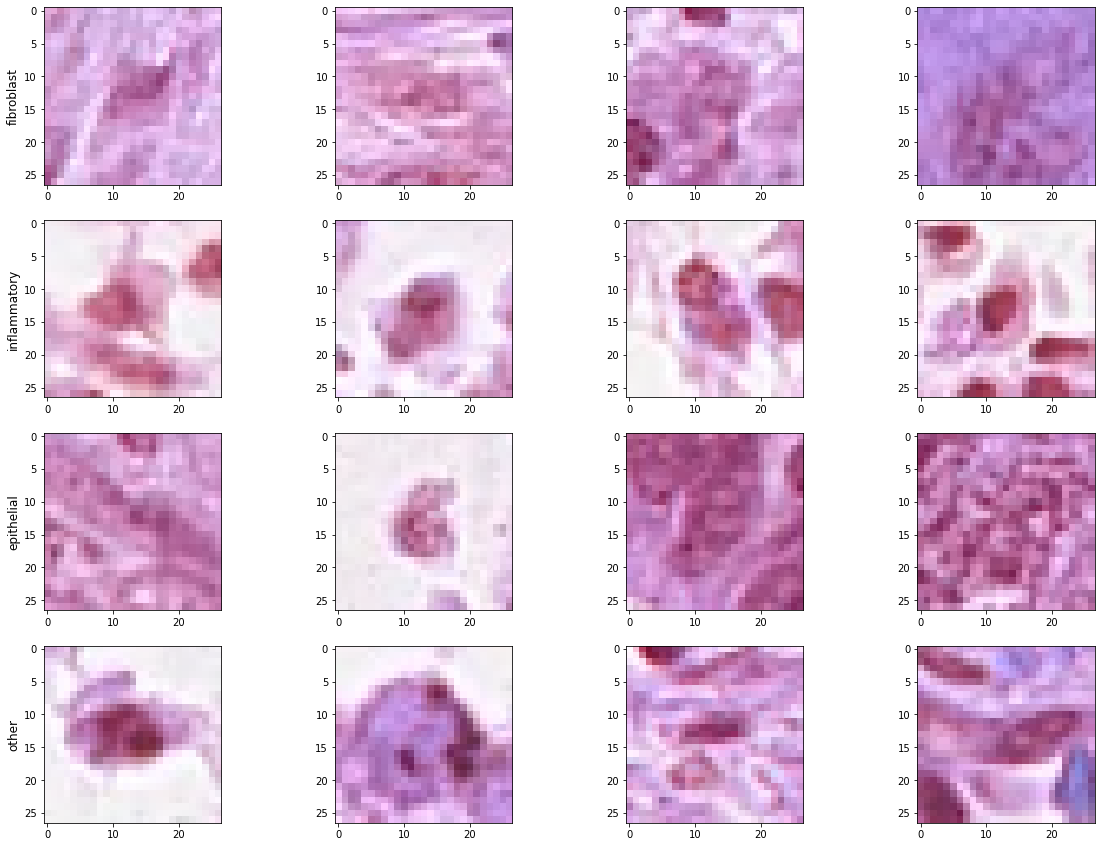

In [130]:
#'fibroblast': 0, 'inflammatory':1, 'epithelial': 2, 'others':3

fibroblast = colon_main.loc[colon_main['cellType'] == 0].sample(4)
inflammatory = colon_main.loc[colon_main['cellType'] == 1].sample(4)
epithelial = colon_main.loc[colon_main['cellType'] == 2].sample(4)
others = colon_main.loc[colon_main['cellType'] == 3].sample(4)

fibroblast_images = []
inflammatory_images = []
epithelial_images = []
other_images = []

for path in fibroblast['ImageName']:
    image_path = "./Image_classification_data/patch_images/" + path
    image = cv.imread(image_path)
    fibroblast_images.append(image)
    
for path in inflammatory['ImageName']:
    image_path = "./Image_classification_data/patch_images/" + path
    image = cv.imread(image_path)
    inflammatory_images.append(image)
    
for path in epithelial['ImageName']:
    image_path = "./Image_classification_data/patch_images/" + path
    image = cv.imread(image_path)
    epithelial_images.append(image)

for path in others['ImageName']:
    image_path = "./Image_classification_data/patch_images/" + path
    image = cv.imread(image_path)
    other_images.append(image)    

fig,axis = plt.subplots(4,4,figsize=(20,15))
for i, image in enumerate(fibroblast_images):
    axis[0,i].imshow(image)
axis[0,0].set_ylabel('fibroblast', size='large')

for i, image in enumerate(inflammatory_images):
    axis[1,i].imshow(image)
axis[1,0].set_ylabel('inflammatory', size='large')

for i, image in enumerate(epithelial_images):
    axis[2,i].imshow(image)
axis[2,0].set_ylabel('epithelial', size='large')

for i, image in enumerate(other_images):
    axis[3,i].imshow(image)
axis[3,0].set_ylabel('other', size='large')


In [4]:
flat_data_arr=[]
target_arr=[]

for img in colon_main['ImageName']:
    path = './Image_classification_data/patch_images/' + img
    image_arr = cv.imread(path)
    img_resized=resize(image_arr,(27, 27, 3))
    flat_data_arr.append(img_resized.flatten())
    target_arr.append(colon_main.loc[colon_main['ImageName'] == img].cellType)
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data_arr)
df['Target']=target
df

,0,1,2,3,4,5,6,7,8,9,...,2178,2179,2180,2181,2182,2183,2184,2185,2186,Target
0,0.929412,0.835294,0.949020,0.913725,0.819608,0.937255,0.898039,0.803922,0.921569,0.890196,...,0.760784,0.592157,0.788235,0.686275,0.517647,0.709804,0.745098,0.576471,0.764706,0
1,0.827451,0.686275,0.866667,0.827451,0.686275,0.878431,0.858824,0.721569,0.913725,0.854902,...,0.905882,0.811765,0.941176,0.933333,0.835294,0.968627,0.956863,0.858824,0.992157,0
2,0.968627,0.952941,0.968627,0.964706,0.949020,0.972549,0.956863,0.937255,0.968627,0.945098,...,0.686275,0.419608,0.635294,0.784314,0.529412,0.745098,0.764706,0.529412,0.745098,0
3,0.949020,0.949020,0.952941,0.945098,0.945098,0.952941,0.945098,0.945098,0.952941,0.949020,...,0.956863,0.827451,0.949020,0.988235,0.854902,0.972549,0.866667,0.729412,0.847059,0
4,0.741176,0.509804,0.741176,0.721569,0.494118,0.729412,0.717647,0.494118,0.733333,0.729412,...,0.945098,0.937255,0.952941,0.949020,0.937255,0.956863,0.956863,0.941176,0.956863,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9891,0.705882,0.541176,0.670588,0.894118,0.729412,0.850980,1.000000,0.878431,0.988235,0.905882,...,0.811765,0.631373,0.776471,0.811765,0.647059,0.776471,0.905882,0.803922,0.921569,2
9892,0.894118,0.678431,0.831373,0.811765,0.568627,0.725490,0.713725,0.486275,0.643137,0.756863,...,0.894118,0.800000,0.901961,0.886275,0.788235,0.894118,0.925490,0.823529,0.929412,2
9893,0.756863,0.552941,0.686275,0.819608,0.658824,0.768627,0.870588,0.737255,0.839216,0.929412,...,0.733333,0.517647,0.662745,0.854902,0.694118,0.819608,0.945098,0.803922,0.917647,2
9894,0.909804,0.792157,0.890196,0.756863,0.572549,0.690196,0.768627,0.572549,0.717647,0.811765,...,1.000000,0.760784,0.890196,0.792157,0.552941,0.694118,0.631373,0.396078,0.545098,2


In [5]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)

In [42]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(loss='hinge', random_state=42)
sgd_clf.fit(x_train, y_train)

SGDClassifier(random_state=42)

In [44]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy')

array([0.57938613, 0.63129973, 0.55761941])

In [46]:
score = sgd_clf.score(x_test, y_test)
score

0.6111111111111112

In [46]:
sgd_clf = SGDClassifier(loss='log', random_state=42, 
                        penalty='l2', alpha=1e-4)
sgd_clf.fit(x_train, y_train)

SGDClassifier(loss='log', random_state=42)

In [55]:
cross_val_score(sgd_clf, x_train, y_train, cv=7, scoring='accuracy')

array([0.64367816, 0.66489832, 0.56321839, 0.66578249, 0.48629531,
       0.67197171, 0.61415929])

In [56]:
score = sgd_clf.score(x_test, y_test)
score

0.6257575757575757

In [131]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [132]:
cell_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [133]:
cell_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               560128    
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


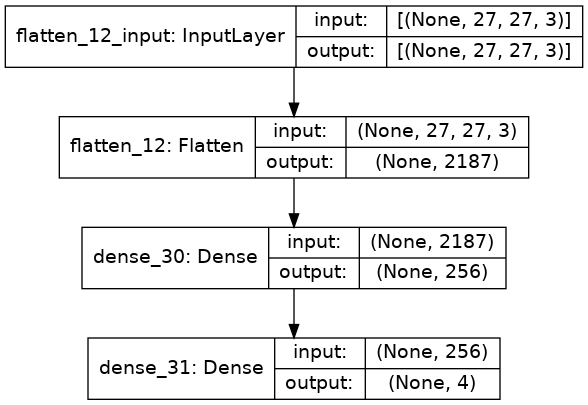

In [134]:
tf.keras.utils.plot_model(cell_model, show_shapes=True)

In [34]:
cell_model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [35]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

cell_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
cell_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

cell_train_generator = cell_train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_validation_generator = cell_val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [36]:
cell_history = cell_model.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=150)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
220/220 [==============================] - 4s 16ms/step - loss: 1.2527 - categorical_accuracy: 0.4635 - val_loss: 1.1939 - val_categorical_accuracy: 0.4805
Epoch 2/150
220/220 [==============================] - 3s 15ms/step - loss: 1.1614 - categorical_accuracy: 0.5215 - val_loss: 1.1246 - val_categorical_accuracy: 0.5629
Epoch 3/150
220/220 [==============================] - 3s 15ms/step - loss: 1.0886 - categorical_accuracy: 0.5604 - val_loss: 1.0549 - val_categorical_accuracy: 0.5760
Epoch 4/150
220/220 [==============================] - 3s 15ms/step - loss: 1.0334 - categorical_accuracy: 0.5868 - val_loss: 1.0383 - val_categorical_accuracy: 0.5503
Epoch 5/150
220/220 [==============================] - 3s 15ms/step - loss: 0.9836 - categorical_accuracy: 0.6185 - val_loss: 0.9743 - val_categorical_accuracy: 0.6726
Epoch 6/150
220/220 [==============================] - 4s 16ms/step - loss: 0.9483 - categorical_accuracy: 0.6363 - val_loss: 0.9245 - val_categorical_accuracy:

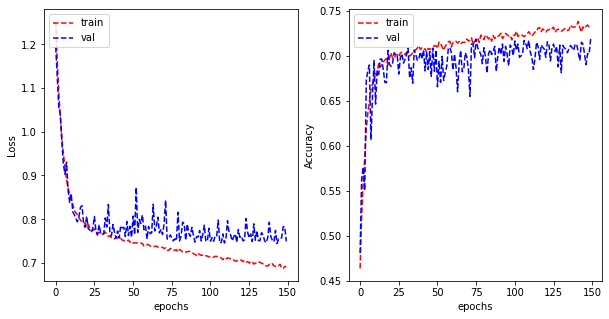

In [37]:
plot_learning_curve(cell_history.history['loss'], cell_history.history['val_loss'], 
                    cell_history.history['categorical_accuracy'], cell_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [38]:
test_data['cellType'] = test_data['cellType'].astype('str')

cell_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

cell_test_generator = cell_test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
cell_model.evaluate(cell_test_generator)

In [ ]:
label_names = {'fibroblast': 0, 'inflammatory':1, 'epithelial': 2, 'others':3}

In [ ]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in cell_test_generator:
        batches = batches + 1
        y_hat = cell_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [ ]:
cell_model.save("predict_celltype")

# Lenet model - Predicting CellType

In [60]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [61]:

train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

cell_type_train_datagen = ImageDataGenerator(
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

cell_type_val_datagen = ImageDataGenerator(
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 32

cell_type_train_generator = cell_type_train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_type_validation_generator = cell_type_val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [8]:
reg_lambda = 0.001

cell_type_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
  
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(48, (5, 5), padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [50]:
cell_type_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 27, 27, 32)        2432      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 9, 9, 48)          38448     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 48)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               196864    
_________________________________________________________________
dense_17 (Dense)             (None, 84)               

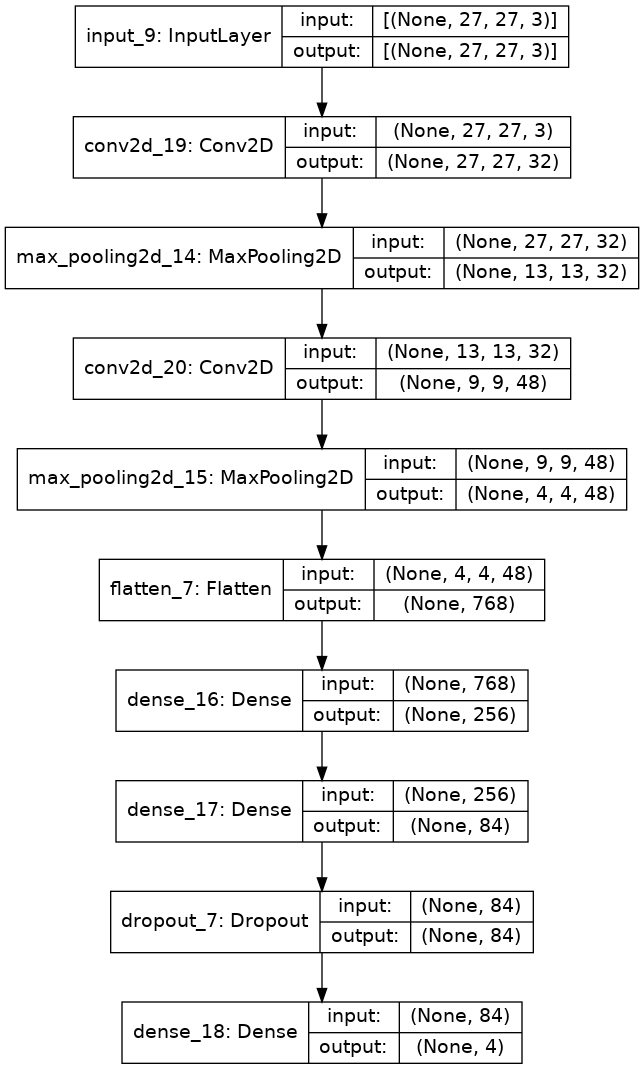

In [51]:
tf.keras.utils.plot_model(cell_type_model, show_shapes=True)

In [52]:
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
cell_type_model .compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [53]:
history = cell_type_model.fit_generator(cell_type_train_generator, 
                                    validation_data = cell_type_validation_generator, 
                                    epochs=150)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator s

Epoch 1/150
186/186 [==============================] - 15s 78ms/step - loss: 0.9810 - categorical_accuracy: 0.5995 - val_loss: 0.9061 - val_categorical_accuracy: 0.6523
Epoch 2/150
186/186 [==============================] - 14s 74ms/step - loss: 0.8820 - categorical_accuracy: 0.6552 - val_loss: 0.8148 - val_categorical_accuracy: 0.6837
Epoch 3/150
186/186 [==============================] - 14s 75ms/step - loss: 0.8318 - categorical_accuracy: 0.6812 - val_loss: 0.8608 - val_categorical_accuracy: 0.6609
Epoch 4/150
186/186 [==============================] - 14s 76ms/step - loss: 0.7924 - categorical_accuracy: 0.6938 - val_loss: 0.7320 - val_categorical_accuracy: 0.7165
Epoch 5/150
186/186 [==============================] - 14s 76ms/step - loss: 0.7668 - categorical_accuracy: 0.7041 - val_loss: 0.7503 - val_categorical_accuracy: 0.7014
Epoch 6/150
186/186 [==============================] - 14s 76ms/step - loss: 0.7558 - categorical_accuracy: 0.7128 - val_loss: 0.7154 - val_categorical_acc

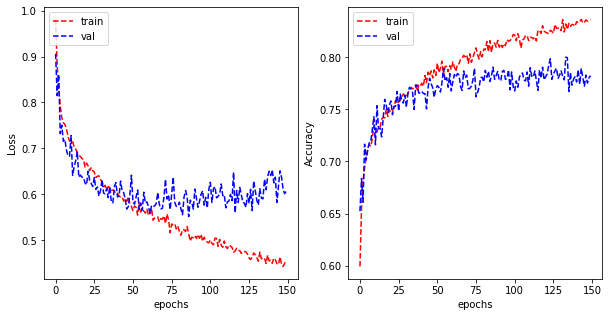

In [56]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [62]:
reg_lambda = 0.001

cell_type_model_reg = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
  
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(48, (5, 5), padding='valid', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), padding='valid', activation='relu',),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [63]:
cell_type_model_reg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 48)          38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          27712     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

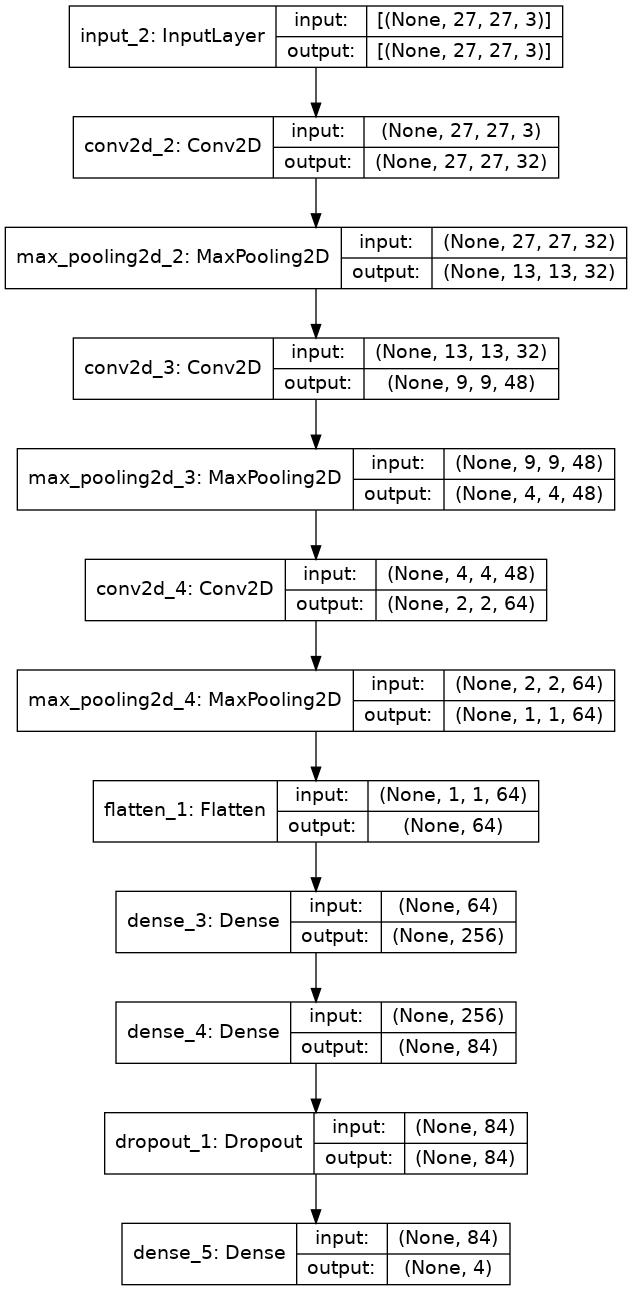

In [11]:
tf.keras.utils.plot_model(cell_type_model_reg, show_shapes=True)

In [64]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
cell_type_model_reg.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [65]:
cell_history_reg = cell_type_model_reg.fit_generator(cell_type_train_generator, 
                                    validation_data = cell_type_validation_generator, 
                                    epochs=100)

Epoch 1/100
186/186 [==============================] - 15s 78ms/step - loss: 1.0485 - categorical_accuracy: 0.5927 - val_loss: 0.8802 - val_categorical_accuracy: 0.6620
Epoch 2/100
186/186 [==============================] - 13s 72ms/step - loss: 0.9229 - categorical_accuracy: 0.6658 - val_loss: 0.8341 - val_categorical_accuracy: 0.6817
Epoch 3/100
186/186 [==============================] - 14s 77ms/step - loss: 0.8664 - categorical_accuracy: 0.6874 - val_loss: 0.7992 - val_categorical_accuracy: 0.7130
Epoch 4/100
186/186 [==============================] - 13s 72ms/step - loss: 0.8469 - categorical_accuracy: 0.6982 - val_loss: 0.7959 - val_categorical_accuracy: 0.7115
Epoch 5/100
186/186 [==============================] - 13s 72ms/step - loss: 0.8328 - categorical_accuracy: 0.7030 - val_loss: 0.7837 - val_categorical_accuracy: 0.7105
Epoch 6/100
186/186 [==============================] - 13s 72ms/step - loss: 0.8089 - categorical_accuracy: 0.7125 - val_loss: 0.7698 - val_categorical_acc

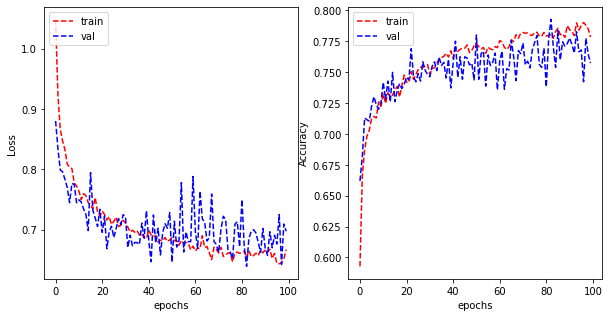

In [66]:
plot_learning_curve(cell_history_reg.history['loss'], cell_history_reg.history['val_loss'], 
                    cell_history_reg.history['categorical_accuracy'], cell_history_reg.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [71]:
cell_type_model_reg.save("predict_celltype.h5")

In [6]:
reg_lambda = 0.001

cell_type_model_reg = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
  
    tf.keras.layers.Conv2D(36, (4, 4), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(48, (3, 3), padding='valid', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

NameError: name 'OUTPUT_CLASSES' is not defined

In [53]:
resnet_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [54]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
resnet_model.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [55]:
cell_history_resnet = cell_type_model_reg.fit_generator(cell_type_train_generator, 
                                    validation_data = cell_type_validation_generator, 
                                    epochs=50)

Epoch 1/50
  1/186 [..............................] - ETA: 17s - loss: 1.0766 - categorical_accuracy: 0.5312

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator s

186/186 [==============================] - 14s 76ms/step - loss: 0.8104 - categorical_accuracy: 0.7093 - val_loss: 0.8134 - val_categorical_accuracy: 0.7024
Epoch 2/50
186/186 [==============================] - 14s 75ms/step - loss: 0.7902 - categorical_accuracy: 0.7121 - val_loss: 0.7735 - val_categorical_accuracy: 0.7150
Epoch 3/50
186/186 [==============================] - 14s 75ms/step - loss: 0.7767 - categorical_accuracy: 0.7270 - val_loss: 0.7367 - val_categorical_accuracy: 0.7468
Epoch 4/50
186/186 [==============================] - 14s 76ms/step - loss: 0.7610 - categorical_accuracy: 0.7273 - val_loss: 0.7969 - val_categorical_accuracy: 0.7160
Epoch 5/50
186/186 [==============================] - 14s 73ms/step - loss: 0.7546 - categorical_accuracy: 0.7305 - val_loss: 0.7576 - val_categorical_accuracy: 0.7317
Epoch 6/50
186/186 [==============================] - 14s 75ms/step - loss: 0.7497 - categorical_accuracy: 0.7322 - val_loss: 0.7111 - val_categorical_accuracy: 0.7448
Epo

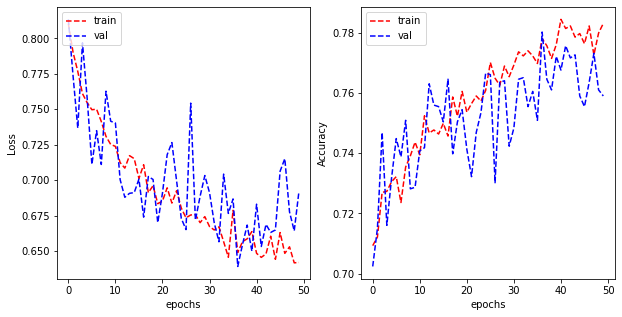

In [56]:
plot_learning_curve(cell_history_resnet.history['loss'], cell_history_resnet.history['val_loss'], 
                    cell_history_resnet.history['categorical_accuracy'], cell_history_resnet.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')


In [ ]:
from keras.applications import ResNet50

resnet_base_model = ResNet50(input_shape=(180,180,3), include_top=False, weights=None)